# Linear fit with constraint
Author: Aleksander Filip Żarnecki (University of Warsaw)

### (0) Import libraries 

In [1]:
import math
from ROOT import *
import numpy as np
from array import array

# For inline image display
from IPython.display import Image

Welcome to JupyROOT 6.24/04


### (1) ROOT settings

In [2]:
# Set ROOT graphics options

gROOT.SetStyle("Plain")

# Default canvas  size

gStyle.SetCanvasDefW(600)
gStyle.SetCanvasDefH(400)
 
# set the margins
  
gStyle.SetPadBottomMargin(0.18)
gStyle.SetPadTopMargin(0.08)
gStyle.SetPadRightMargin(0.08)
gStyle.SetPadLeftMargin(0.17)

# set the number of divisions to show

gStyle.SetNdivisions(510, "xy")

# show grid

gStyle.SetPadGridX(1)
gStyle.SetPadGridY(1)

# border ploted only around statistics

gStyle.SetPadBorderMode(0)
gStyle.SetFrameBorderMode(0)
gStyle.SetLegendBorderSize(0)
gStyle.SetTitleBorderSize(0)
gStyle.SetStatBorderSize(1)

# Text sizes

gStyle.SetTextSize(0.05)
gStyle.SetTitleSize(0.06,"xyz")
gStyle.SetLabelSize(0.05,"xyz")

gStyle.SetLabelOffset(0.015,"xyz")
gStyle.SetTitleOffset(1.2,"yz")
gStyle.SetTitleOffset(1.0,"x")

# Font settings

font = 42
gStyle.SetTitleFont(font)
gStyle.SetTitleFontSize(0.05)
gStyle.SetStatFont(font)
gStyle.SetStatFontSize(0.06)
gStyle.SetTextFont(font)
gStyle.SetLabelFont(font,"xyz")
gStyle.SetTitleFont(font,"xyz")
gStyle.SetLegendFont(font)

# Line settings

gStyle.SetHistLineWidth(2)
gStyle.SetFrameLineWidth(2)
gStyle.SetFuncWidth(2)
gStyle.SetHistLineColor(kBlue)
gStyle.SetFuncColor(kRed)

# Log scale
gStyle.SetOptLogy(0)

# Histogram title
gStyle.SetOptTitle(1)  

# Histogram statistics
gStyle.SetOptStat(1100)

# Fit results
gStyle.SetOptFit(0) 


### (2) Definition of model

Consider controlled parameter range is [-1,1]

In [47]:
# True functional dependece

def mytrue(x):
    
    val = 0.5 + 0.5*np.cos(x*np.pi + 0.5*np.cos(x*np.pi/2.))

    return val

# Basic functions:  1, x, x^2, x^3 ...

def myfun(x,ifun):

    return np.power(x,ifun)

# Full model

def mymodel(x,par):

    val = np.zeros(x.size)
    
    for ip in range(par.size):
        val+=par[ip]*myfun(x,ip)
        
    return val


### (3) Generate pseudo data to fit

In [48]:
# Considered values of x

xvec = np.linspace(-0.95,0.95,20)

# Measurement precision

svec = np.linspace(0.02,0.03,xvec.size)
s2vec = svec*svec

# Pseudo-data

yvec = np.random.normal(mytrue(xvec),svec)


### (4)  Linear fit without constraint

In [115]:
# Number of model functions to consider 

Nfun = 8

A = np.zeros((Nfun,Nfun))

B = np.zeros(Nfun)

for l in range(Nfun):
    fl = myfun(xvec,l)
    B[l] = np.sum(fl*yvec/s2vec)
    for k in range(Nfun):
        fk = myfun(xvec,k)
        A[l,k] = np.sum(fl*fk/s2vec)


# Inverse of matrix

Cov = np.linalg.inv(A)

# Solution to the problem

par = Cov @ B

# Parameter uncertainties

epar = np.sqrt(np.diagonal(Cov))

print("\n Fit results:\n\n     par         sigma_p\n")

for ip in range(par.size):
    print("  %8.3f  +/- %6.3f " % (par[ip],epar[ip]))

# Calculate correlation matrix, including rounding

Corr = Cov

print("\n Correlation matrix\n")
for ip in range(par.size):
    for jp in range(par.size):
        Corr[ip,jp]=int(1000.*Corr[ip,jp]/epar[ip]/epar[jp]+0.5)/1000.
        
    print(Corr[ip,:])

# Fitted function

fvec = mymodel(xvec,par) 

# Chi^2 printout

chi2 = np.sum((yvec-fvec)**2/s2vec)

print("\n chi^2 =  %8.3f   chi^2/Ndf = %8.5f " % (chi2,chi2/(xvec.size-Nfun)))

# print("\n  x       y         f(x) ")
# for ix in range(xvec.size):
#     print("%6.3f  %8.5f  %8.5f " % (xvec[ix],yvec[ix],fvec[ix]))


 Fit results:

     par         sigma_p

     0.943  +/-  0.012 
    -0.730  +/-  0.066 
    -2.128  +/-  0.157 
     2.036  +/-  0.500 
     1.421  +/-  0.445 
    -2.050  +/-  1.086 
    -0.244  +/-  0.331 
     0.745  +/-  0.691 

 Correlation matrix

[ 1.     0.078 -0.745 -0.096  0.604  0.102 -0.522 -0.102]
[ 0.078  1.    -0.056 -0.915  0.046  0.822 -0.038 -0.749]
[-0.745 -0.056  1.     0.129 -0.959 -0.161  0.902  0.177]
[-0.096 -0.915  0.129  1.    -0.122 -0.975  0.116  0.936]
[ 0.604  0.046 -0.959 -0.122  1.     0.168 -0.984 -0.192]
[ 0.102  0.822 -0.161 -0.975  0.168  1.    -0.164 -0.988]
[-0.522 -0.038  0.902  0.116 -0.984 -0.164  1.     0.196]
[-0.102 -0.749  0.177  0.936 -0.192 -0.988  0.196  1.   ]

 chi^2 =    15.470   chi^2/Ndf =  1.28917 


### (5)  Linear fit with constraint

In [121]:
# Number of constraints

Ncon = 2

# Constraints given in matrix form    D @ par = E

D = np.zeros((Ncon,Nfun))
E = np.zeros(Ncon)

# First constraing:  value at 1 is 0

for l in range(Nfun):
    D[0,l]=1.0

E[0] = 0.0
    
# Second constraint: value at -1 is 0

for l in range(Nfun):
    D[1,l]=np.power(-1.0,l)

E[1] = 0.0


In [122]:
# Work arrays for new fit

Ac = np.zeros((Nfun+Ncon,Nfun+Ncon))

Bc = np.zeros(Nfun+Ncon)

for l in range(Nfun):
    fl = myfun(xvec,l)
    Bc[l] = np.sum(fl*yvec/s2vec)
    for k in range(Nfun):
        fk = myfun(xvec,k)
        Ac[l,k] = np.sum(fl*fk/s2vec)

# Add constraints

    for k in range(Nfun,Nfun+Ncon):
        Ac[k,l] = D[k-Nfun,l]
        Ac[l,k] = D[k-Nfun,l]

for l in range(Nfun,Nfun+Ncon):
    Bc[l]=E[l-Nfun]


In [123]:
# Inverse of matrix

CCov = np.linalg.inv(Ac)

# print("\n Covariance matrix\n")
#
# for ip in range(Bc.size):
#    print(CCov[ip,:])

# Solution to the problem

parc = CCov @ Bc

# Parameter uncertainties
# consider covariance matrix for parameters only

Cpar = CCov[:Nfun,:Nfun]

eparc = np.sqrt(np.diagonal(Cpar))

print("\n Fit results:\n\n     par         sigma_p\n")

for ip in range(Nfun):
    print("  %8.3f  +/- %6.3f " % (parc[ip],eparc[ip]))

# Calculate correlation matrix, including rounding

CCorr = Cpar

# Consider covariance matrix for fit parameters only

#print("\n Correlation matrix\n")
#for ip in range(Nfun):
#    for jp in range(Nfun):
#        CCorr[ip,jp]=int(1000.*CCorr[ip,jp]/eparc[ip]/eparc[jp]+0.5)/1000.
#        
#    print(CCorr[ip,:])

# Fitted function

fcvec = mymodel(xvec,parc[:Nfun]) 

# Chi^2 printout

chi2c = np.sum((yvec-fcvec)**2/s2vec)

print("\n chi^2 =  %8.3f   chi^2/Ndf = %8.5f " % (chi2c,chi2c/(xvec.size-Nfun+Ncon)))

# print("\n  x       y         f(x) ")
# for ix in range(xvec.size):
#     print("%6.3f  %8.5f  %8.5f " % (xvec[ix],yvec[ix],fcvec[ix]))


 Fit results:

     par         sigma_p

     0.942  +/-  0.012 
    -0.728  +/-  0.060 
    -2.111  +/-  0.134 
     2.017  +/-  0.402 
     1.361  +/-  0.334 
    -2.008  +/-  0.771 
    -0.192  +/-  0.214 
     0.720  +/-  0.432 

 chi^2 =    15.520   chi^2/Ndf =  1.10860 


### (6)  Linear fit of reduced model

In [124]:
# Number of parameters in "reduced function" 

Nred = Nfun-Ncon

# reduced model
# Constrains included in the functions formula
# For given number of input parameters, additional terms added to
# take constraints into account (one for even and one for odd terms)

def myred(x,par):

    parsum = np.zeros(2)
    
    for ip in range(par.size):
        parsum[ip%2] -= par[ip]
        
    npar = np.zeros(par.size+2)

    npar[:par.size]=par
    npar[par.size] = parsum[par.size%2]
    npar[par.size+1] = parsum[(par.size+1)%2]
    
    val = np.zeros(x.size)
    
    for ip in range(npar.size):
        val+=npar[ip]*myfun(x,ip)
        
    return val


Ar = np.zeros((Nred,Nred))

Br = np.zeros(Nred)

# additional terms for even and odd powers

lc = np.empty(2, dtype=int)

if Nred%2 == 0 :
    lc[0] = Nred
    lc[1] = Nred+1
else:    
    lc[0] = Nred+1
    lc[1] = Nred

# Calculate arrays including constrain terms

for l in range(Nred):
    fl = myfun(xvec,l) - myfun(xvec,lc[l%2])
    Br[l] = np.sum(fl*yvec/s2vec)
    for k in range(Nred):
        fk = myfun(xvec,k) - myfun(xvec,lc[k%2])
        Ar[l,k] = np.sum(fl*fk/s2vec)


# Inverse of matrix

RCov = np.linalg.inv(Ar)

# Solution to the problem

parr = RCov @ Br

# Parameter uncertainties

eparr = np.sqrt(np.diagonal(RCov))

print("\n Fit results:\n\n     par         sigma_p\n")

for ip in range(parr.size):
    print("  %8.3f  +/- %6.3f " % (parr[ip],eparr[ip]))

# Calculate correlation matrix, including rounding

RCorr = RCov

print("\n Correlation matrix\n")
for ip in range(parr.size):
    for jp in range(parr.size):
        RCorr[ip,jp]=int(1000.*RCorr[ip,jp]/eparr[ip]/eparr[jp]+0.5)/1000.
        
    print(RCorr[ip,:])

# Fitted function

frvec = myred(xvec,parr) 

# Chi^2 printout

chi2r = np.sum((yvec-frvec)**2/s2vec)

print("\n chi^2 =  %8.3f   chi^2/Ndf = %8.5f " % (chi2r,chi2r/(xvec.size-Nred)))

# print("\n  x       y         f(x) ")
# for ix in range(xvec.size):
#     print("%6.3f  %8.5f  %8.5f " % (xvec[ix],yvec[ix],fvec[ix]))


 Fit results:

     par         sigma_p

     0.942  +/-  0.012 
    -0.728  +/-  0.060 
    -2.111  +/-  0.134 
     2.017  +/-  0.402 
     1.361  +/-  0.334 
    -2.008  +/-  0.771 

 Correlation matrix

[ 1.     0.083 -0.746 -0.102  0.608  0.109]
[ 0.083  1.    -0.06  -0.915  0.049  0.822]
[-0.746 -0.06   1.     0.137 -0.961 -0.17 ]
[-0.102 -0.915  0.137  1.    -0.13  -0.975]
[ 0.608  0.049 -0.961 -0.13   1.     0.177]
[ 0.109  0.822 -0.17  -0.975  0.177  1.   ]

 chi^2 =    15.520   chi^2/Ndf =  1.10860 


### (7) Draw data and fit

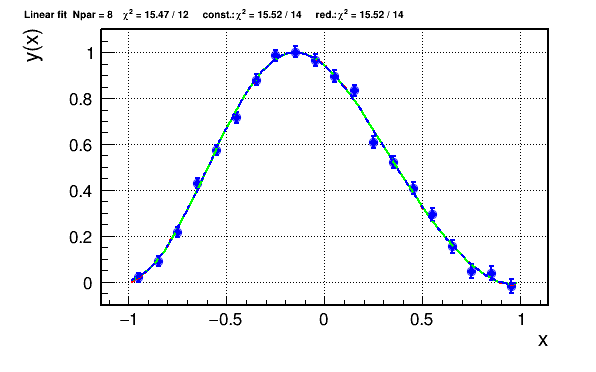

Warning in <TCanvas::Constructor>: Deleting canvas with same name: cexp
Info in <TCanvas::Print>: png file 08_const7_8.png has been created


In [125]:
# Lin scale

gStyle.SetOptLogy(0)

# Create plot canvas

# gStyle.SetCanvasDefH(600)  # Default is 600 x 400

cexp = TCanvas('cexp')
   
## Pseudo-data graph

dgr=TGraphErrors(xvec.size,array('d',xvec),array('d',yvec),0,array('d',svec))
dgr.SetNameTitle('dgr','Linear fit  Npar = '+str(Nfun)+'     #chi^{2} = '+str(int(100*chi2+0.5)/100.)+' / '+str(xvec.size-Nfun)
                +'     const.: #chi^{2} = '+str(int(100*chi2c+0.5)/100.)+' / '+str(xvec.size-Nfun+Ncon)
                +'     red.: #chi^{2} = '+str(int(100*chi2r+0.5)/100.)+' / '+str(xvec.size-Nred))
    
# Graphic style

dgr.GetXaxis().SetTitle("x")
dgr.GetYaxis().SetTitle("y(x)")
dgr.SetMarkerStyle(20)
dgr.SetMarkerSize(1.0)
dgr.SetMarkerColor(4)
dgr.SetLineColor(4)
dgr.SetLineWidth(2)
dgr.SetLineStyle(1)
   
dgr.SetMinimum(-0.1)
dgr.SetMaximum(1.1)
dgr.Draw('AWP')

# Fitted dependence wraper for root

def myfit(x, par):
    
    val = 0
    
    for ip in range(Nfun):
        val+=par[ip]*myfun(x[0],ip)
        
    return val

# Reduced dependence wraper for root

def myrfit(x, fpar):
    
    xvec = np.array([x[0]])

    tpar = np.empty(Nred)
    for ip in range(Nred): tpar[ip]=fpar[ip]
    
    val = myred(xvec,tpar)
        
    return val


# Define user function

fexp=TF1("fexp",myfit,-1.,1.,Nfun)
fcexp=TF1("fcexp",myfit,-1.,1.,Nfun)
frexp=TF1("frexp",myrfit,-1.,1.,Nred)

for ip in range(Nfun):
    fexp.SetParameter(ip,par[ip])
    fcexp.SetParameter(ip,parc[ip])
    
for ip in range(Nred):
    frexp.SetParameter(ip,parr[ip])
    
fexp.SetNpx(50)
fexp.SetLineStyle(7)
fexp.SetLineColor(2)

fcexp.SetNpx(50)
fcexp.SetLineStyle(1)
fcexp.SetLineColor(3)

frexp.SetNpx(50)
frexp.SetLineStyle(7)
frexp.SetLineColor(4)

fexp.DrawCopy("Csame")
fcexp.DrawCopy("Csame")
frexp.DrawCopy("Csame")

cexp.Update()
fname = '08_const7_'+str(Nfun)+'.png'
cexp.Print(fname)

Image(filename=fname)